---
title: "Feature selection and extraction"
author: "phonchi"
date: "03/20/2023"
format: 
  html:
    toc: true
    code-line-numbers: true
    code-tools: true
---

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/05_Feature_selection_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/05_Feature_selection_extraction.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br/>

## Setup

In [ ]:
!pip install Boruta -qq
!pip install opentsne -qq
!pip install umap-learn -qq

In [2]:
# Scientific computing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

# Preprocessing and datasets
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

# Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

from boruta import BorutaPy

# Feature extraction
from sklearn.decomposition import PCA
from openTSNE import TSNE as oTSNE
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import FeatureAgglomeration

## Feature selection

The classes in the `sklearn.feature_selection` module can be used for feature selection/extraction methods on datasets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.

### Removing low variance features

Suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is `0.8 * (1 - 0.8)`

In [3]:
X = pd.DataFrame([[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]])
X

,0,1,2
0,0,0,1
1,0,1,0
2,1,0,0
3,0,1,1
4,0,1,0
5,0,1,1


In [4]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8))).set_output(transform="pandas")
sel.fit_transform(X)

,x1,x2
0,0,1
1,1,0
2,0,0
3,1,1
4,1,0
5,1,1


As expected, `VarianceThreshold()` has removed the first column, which has a probability of containing a zero.

### Univariate feature selection

`Scikit-learn` exposes feature selection routines as objects that implement the `transform()` method. For instance, we can perform a $\chi^2$ test to the samples to retrieve only the two best features as follows:

In [5]:
X, y = load_iris(return_X_y=True, as_frame=True) # Load the iris data set
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [6]:
selecter = SelectKBest(chi2, k=2).set_output(transform="pandas")
X_new = selecter.fit_transform(X, y)
X_new

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


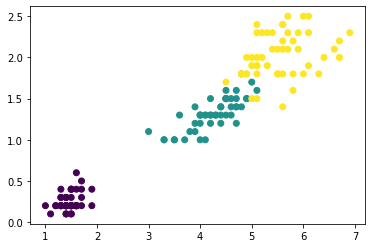

In [7]:
plt.scatter(X_new.iloc[:,0], X_new.iloc[:,1], c=y)
plt.show()

These objects take as input a scoring function that returns univariate scores/p-values (or only scores for `SelectKBest()` and `SelectPercentile()`):

* For regression: `r_regression`, `f_regression`, `mutual_info_regression`
* For classification: `chi2`, `f_classif`, `mutual_info_classif`

The methods based on F-test estimate the degree of linear dependency between two random variables. For example, we create a dataset with two informative features among a hundred. To simplify our example, we do not include either redundant or repeated features. In addition, We will explicitly not shuffle the dataset to ensure that the informative features will correspond to the three two columns of X.

In [8]:
# Generate synthetic dataset

data, target = make_classification(
    n_samples=5000,
    n_features=100,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=0,
    shuffle = False  # So that we know the informative freatures are X[:, n_informative + n_redundant + n_repeated:].
)

We will create two machine learning pipelines. 

1. The former will be a random forest that will use all available features.

2. The latter will also be a random forest, but we will add a feature selection step to train this classifier. 

In [9]:
# Let’s create the model without any feature selection
model_without_selection = RandomForestClassifier(n_jobs=2)

In [10]:
# Then, let’s create a pipeline where the first stage will make the feature selection processing.
model_with_selection = make_pipeline(
    SelectKBest(score_func=f_classif, k=2), # Feature slection
    RandomForestClassifier(n_jobs=2),       # Model
)

We will measure the average time spent to train each pipeline and make it predict. Besides, we will compute the testing score of the model. We will collect these results via cross-validation.

In [11]:
# Let’s start with the random forest without feature selection. We will store the results into a dataframe.
cv_results_without_selection = cross_validate(model_without_selection, data, target)
cv_results_without_selection = pd.DataFrame(cv_results_without_selection)

In [12]:
# Now, we will repeat the process for the pipeline incorporating the feature selection.
cv_results_with_selection = cross_validate(model_with_selection, data, target, return_estimator=True)
cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

To analyze the results, we will merge the results from the two pipeline in a single pandas dataframe.

In [13]:
cv_results = pd.concat(
    [cv_results_without_selection, cv_results_with_selection],
    axis=1,
    keys=["Without feature selection", "With feature selection"],
)

# swap the level of the multi-index of the columns
cv_results = cv_results.swaplevel(axis="columns")

Let’s first analyze the train and score time for each pipeline.

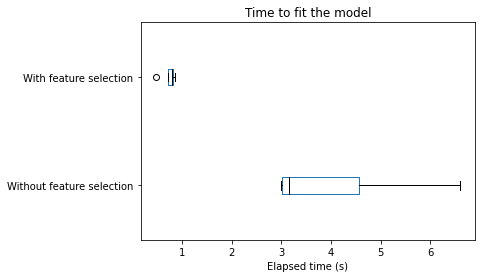

In [14]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
cv_results["fit_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to fit the model")

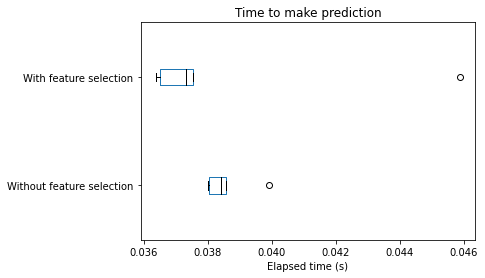

In [15]:
cv_results["score_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to make prediction")

We can draw the same conclusions for both training and scoring elapsed time: selecting the most informative features speed-up our pipeline. Of course, such speed-up is beneficial only if the generalization performance in terms of metrics remain the same. Let’s check the testing score.

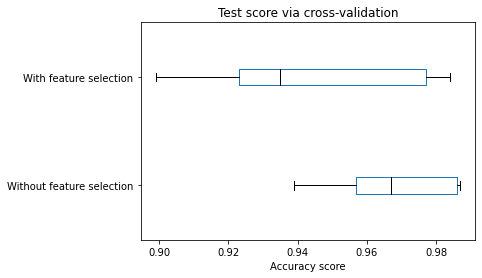

In [16]:
cv_results["test_score"].plot.box(color=color, vert=False)
plt.xlabel("Accuracy score")
_ = plt.title("Test score via cross-validation")

We can observe that the model’s generalization performance selecting a subset of features decreases compared with the model using all available features. Since we generated the dataset, we can infer that the decrease is because of the selection. **The feature selection algorithm did not choose the two informative features.**

In [17]:
for idx, pipeline in enumerate(cv_results_with_selection["estimator"]):
    print(
        f"Fold #{idx} - features selected are: "
        f"{np.argsort(pipeline[0].scores_)[-2:]}"
    )

Fold #0 - features selected are: [30  1]
Fold #1 - features selected are: [10  1]
Fold #2 - features selected are: [10  1]
Fold #3 - features selected are: [30  1]
Fold #4 - features selected are: [61  1]


We see that the feature 1 is always selected while the other feature varies depending on the cross-validation fold.

If we would like to keep our score with similar generalization performance, **we could choose another metric to perform the test or select more features.** For instance, we could select the number of features based on a specific percentile of the highest scores.

#### Mutual information

The [*Automobile*](https://www.kaggle.com/toramky/automobile-dataset) dataset consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's `price` (the target) from 23 of the car's features, such as `make`, `body_style`, and `horsepower`. In this example, we'll rank the features with mutual information and investigate the results by data visualization. (The original dataset requires data cleaning, you could refer to https://skill-lync.com/student-projects/project-1-1299 for more details)

In [ ]:
# Uncpmment below if you are using Kaggle
#!pip install gdown

In [18]:
!gdown --fuzzy https://drive.google.com/file/d/1FoCRK2LQBo1hlPWK2fDDcOjjy-DnPiJw/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1FoCRK2LQBo1hlPWK2fDDcOjjy-DnPiJw
To: /content/autos.csv
100% 21.6k/21.6k [00:00<00:00, 31.6MB/s]


In [19]:
df = pd.read_csv("autos.csv") # Clean version
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The `scikit-learn` algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that have a `float` dtype is *not* discrete. Categoricals (`object` or `categorial` dtype) can be treated as discrete by giving them a label encoding

In [21]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
# A way to perfrom label encoding see https://pandas.pydata.org/docs/reference/api/pandas.factorize.html
    X[colname], _ = X[colname].factorize() 

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

`Scikit-learn` has two mutual information metrics in its `feature_selection` module: one for real-valued targets (`mutual_info_regression()`) and one for categorical targets (`mutual_info_classif()`). Our target, `price`, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [22]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          1.436041
highway_mpg          0.948495
length               0.615407
bore                 0.497058
stroke               0.385846
num_of_cylinders     0.331445
compression_ratio    0.132048
fuel_type            0.047279
Name: MI Scores, dtype: float64

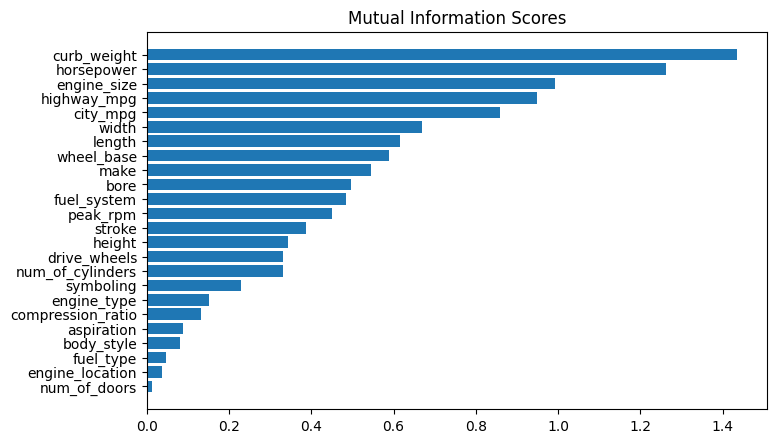

In [23]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

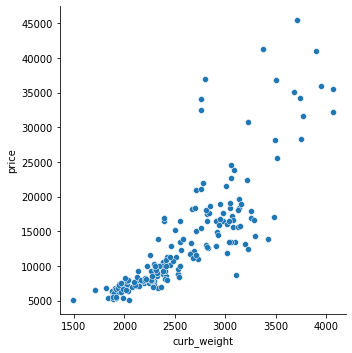

In [24]:
# As we might expect, the high-scoring `curb_weight` feature exhibits a strong relationship with `price`, the target.
sns.relplot(x="curb_weight", y="price", data=df)

The `fuel_type` feature has a fairly low MI score, but as we can see from the figure below, it clearly separates two `price` populations with different trends within the `horsepower` feature. **This indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all.** Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

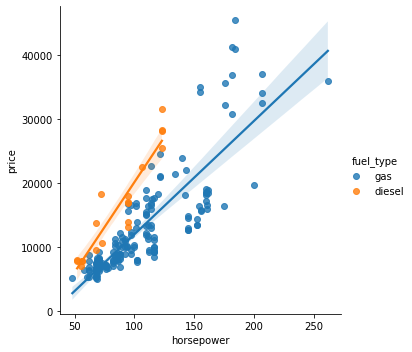

In [25]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df)

### Sequential feature selection

Sequential Feature Selection is available in the `SequentialFeatureSelector` transformer. SFS can be either forward or backward:

* Forward-SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero feature and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the `n_features_to_select` parameter.

* Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set. The direction parameter controls whether forward or backward SFS is used.

> In general, forward and backward selection do not yield equivalent results. Also, one may be much faster than the other depending on the requested number of selected features: if we have 10 features and ask for 7 selected features, forward selection would need to perform 7 iterations while backward selection would only need to perform 3.

In [26]:
X, y = load_iris(return_X_y=True, as_frame=True)
knn = KNeighborsClassifier(n_neighbors=3)

In [27]:
sfs = SequentialFeatureSelector(knn, n_features_to_select=2, direction='forward').set_output(transform="pandas")
sfs.fit(X, y)

SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                          n_features_to_select=2)

In [28]:
 df = sfs.transform(X)
 df

,sepal length (cm),petal width (cm)
0,5.1,0.2
1,4.9,0.2
2,4.7,0.2
3,4.6,0.2
4,5.0,0.2
...,...,...
145,6.7,2.3
146,6.3,1.9
147,6.5,2.0
148,6.2,2.3


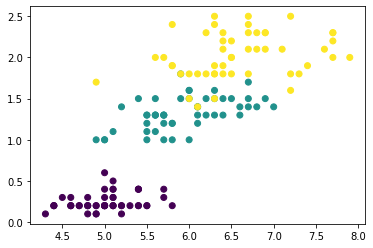

In [29]:
plt.scatter(df.iloc[:,0], df.iloc[:,1],c=y)
plt.show()

### Feature selection from model

`SelectFromModel` is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as `coef_`, `feature_importances_`) or via an `importance_getter` callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter. 

Apart from specifying the threshold numerically, there are built-in heuristics for finding a threshold using a string argument. **Available heuristics are “mean”, “median” and float multiples of these like “0.1*mean”. In combination with the threshold criteria, one can use the `max_features` parameter to set a limit on the number of features to select.**

In [30]:
X, y = load_iris(return_X_y=True, as_frame=True)

In [31]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
model = SelectFromModel(lsvc).set_output(transform="pandas")

In [32]:
X_new = model.fit_transform(X,y) # We use threshold instead or max_features here
X_new

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,sepal length (cm),sepal width (cm),petal length (cm)
0,5.1,3.5,1.4
1,4.9,3.0,1.4
2,4.7,3.2,1.3
3,4.6,3.1,1.5
4,5.0,3.6,1.4
...,...,...,...
145,6.7,3.0,5.2
146,6.3,2.5,5.0
147,6.5,3.0,5.2
148,6.2,3.4,5.4


### A Concret example

The following dataset is our old friend which is a record of neighborhoods in California district, predicting the median house value (target) given some information about the neighborhoods, as the average number of rooms, the latitude, the longitude or the median income of people in the neighborhoods (block).

In [33]:
X, y = fetch_california_housing(as_frame=True, return_X_y=True)

In [34]:
# To speed up the computation, we take the first 10,000 samples
X = X[:10000]
y = y[:10000]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


The feature reads as follow:

* `MedInc`: median income in block
* `HouseAge`: median house age in block
* `AveRooms`: average number of rooms
* `AveBedrms`: average number of bedrooms
* `Population`: block population
* `AveOccup`: average house occupancy
* `Latitude`: house block latitude
* `Longitude`: house block longitude
* `MedHouseVal`: Median house value in 100k$ (target)

To assert the quality of our inspection technique, **let’s add some random feature that won’t help the prediction (un-informative feature)**

In [35]:
# Adding random features
rng = np.random.RandomState(0)
bin_var = pd.Series(rng.randint(0, 2, X.shape[0]), name='rnd_bin')
num_var = pd.Series(np.arange(X.shape[0]), name='rnd_num')
X_with_rnd_feat = pd.concat((X, bin_var, num_var), axis=1)
X_with_rnd_feat

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,rnd_bin,rnd_num
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,0,0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,1,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,1,2
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,0,3
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,1,4
...,...,...,...,...,...,...,...,...,...,...
9995,4.0775,10.0,6.140900,1.025440,1275.0,2.495108,39.14,-121.03,0,9995
9996,4.0848,8.0,6.350394,1.091864,1977.0,2.594488,39.13,-121.07,1,9996
9997,3.6333,7.0,7.243455,1.107330,1143.0,2.992147,39.11,-121.05,0,9997
9998,3.4630,8.0,6.363636,1.166297,1307.0,2.898004,39.08,-121.04,1,9998


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_with_rnd_feat, y, random_state=42)

In linear models, the target value is modeled as a linear combination of the features.

In [37]:
model = RidgeCV()

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.6049524592207427
model score on testing data: 0.5863921053581754


Our linear model obtains a score of .60, so it explains a significant part of the target. Its coefficient should be somehow relevant. Let’s look at the coefficient learnt

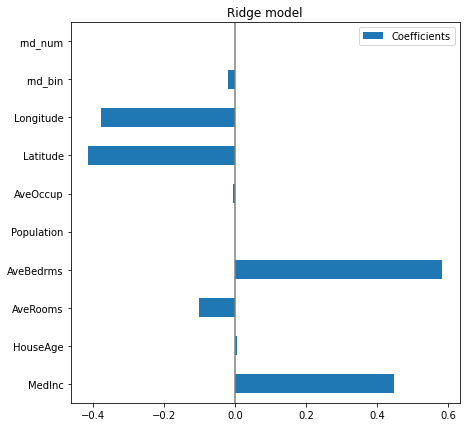

In [38]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

The `AveBedrms` have the higher coefficient. However, we can’t compare the magnitude of these coefficients directly, since they are not scaled. Indeed, `Population` is an integer which can be thousands, while `AveBedrms` is around 4 and `Latitude` is in degree.

So the `Population` coefficient is expressed in `“100k$/habitant”` while the `AveBedrms` is expressed in `“100k$/nb of bedrooms”` and the Latitude coefficient in `“100k$/degree”`. We see that changing population by one does not change the outcome, while as we go south (latitude increase) the price becomes cheaper. Also, adding a bedroom (keeping all other feature constant) shall rise the price of the house by `80k$`.

So looking at the coefficient plot to gauge feature importance can be misleading as some of them vary on a small scale, while others vary a lot more, several decades. **So before any interpretation, we need to scale each column (removing the mean and scaling the variance to 1).**

In [39]:
model = make_pipeline(StandardScaler(), RidgeCV())

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.6049222473801685
model score on testing data: 0.586090835494786


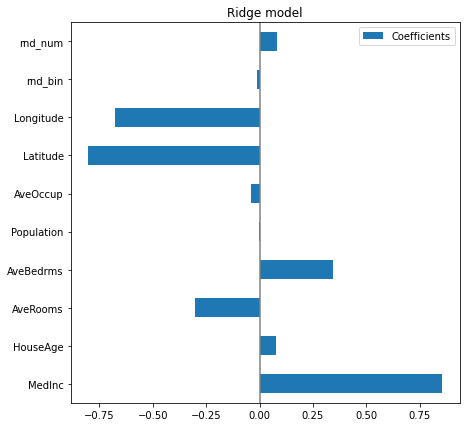

In [40]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Now that the coefficients have been scaled, we can safely compare them. The `MedInc` feature, with `longitude` and `latitude` are the three variables that most influence the model.

The plot above tells us about dependencies between a specific feature and the target when all other features remain constant, i.e., conditional dependencies. An increase of the `HouseAge` will induce an increase of the price when all other features remain constant. On the contrary, an increase of the `AveRooms` will induce an decrease of the price when all other features remain constant.

We can check the coefficient variability through cross-validation: it is a form of data perturbation.

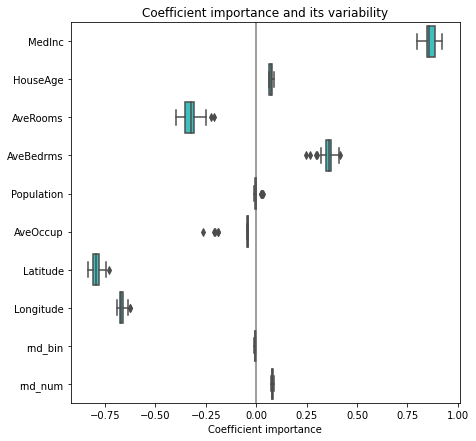

In [41]:
cv_model = cross_validate(
   model, X_with_rnd_feat, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
   return_estimator=True, n_jobs=2
)
coefs = pd.DataFrame(
   [model[1].coef_
    for model in cv_model['estimator']],
   columns=X_with_rnd_feat.columns
)
plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

Now if we want to select the four features which are the most important according to the coefficients. The `SelectFromModel()` is meant just for that. `SelectFromModel()` accepts a `threshold` parameter and will select the features whose importance (defined by the coefficients) are above this threshold.

In [42]:
model

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())])

In [43]:
importance = np.abs(model[1].coef_)
threshold = np.sort(importance)[-5] + 0.01

In [44]:
sfm = SelectFromModel(model[1], threshold=threshold).fit(X, y)
print(f"Features selected by SelectFromModel: {sfm.get_feature_names_out()}")

Features selected by SelectFromModel: ['MedInc' 'AveBedrms' 'Latitude' 'Longitude']


#### Linear models with sparse coefficients (Lasso)

In it important to keep in mind that the associations extracted depend on the model. To illustrate this point we consider a Lasso model, that performs feature selection with a L1 penalty. Let us fit a Lasso model with a strong regularization parameters `alpha`

In [45]:
model = make_pipeline(StandardScaler(), Lasso(alpha=.015))

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.5933235371761756
model score on testing data: 0.5673786563118284


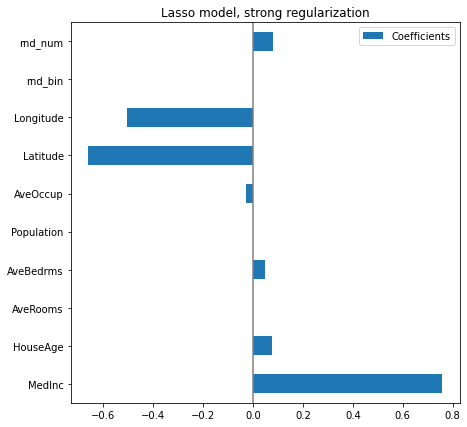

In [46]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Lasso model, strong regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Here the model score is a bit lower, because of the strong regularization. However, it has zeroed out 3 coefficients, selecting a small number of variables to make its prediction.

#### Randomforest with feature importance

On some algorithms, there are some feature importance methods, inherently built within the model. It is the case in RandomForest models. Let’s investigate the built-in `feature_importances_` attribute.

In [47]:
model = RandomForestRegressor()

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.9796643318943656
model score on testing data: 0.8429137479202747


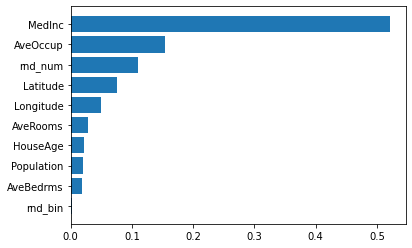

In [48]:
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

`MedInc` is still the most important feature. It also has a small bias toward high cardinality features, such as the noisy feature `rnd_num`, which are here predicted having `0.1` importance, more than `HouseAge` (which has low cardinality).

#### Feature importance by permutation

We introduce here a new technique to evaluate the feature importance of any given fitted model. It basically shuffles a feature and sees how the model changes its prediction. Thus, the change in prediction will correspond to the feature importance.

In [49]:
# Any model could be used here

model = RandomForestRegressor()
model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.9795458070557226
model score on testing data: 0.8448700648905965


In [50]:
r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42) # Notice that the model are already fitted

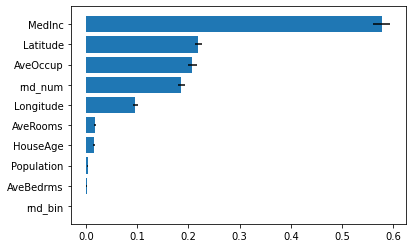

In [51]:
fig, ax = plt.subplots()

indices = r.importances_mean.argsort()
plt.barh(range(len(indices)), r.importances_mean[indices], xerr=r.importances_std[indices])

ax.set_yticks(range(len(indices)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

We see again that the feature `MedInc`, `Latitude` and `Longitude` are important for the model. We note that our random variable `rnd_num` is now less important than `Latitude`. Indeed, the feature importance built-in in `RandomForest` has bias for continuous data, such as `AveOccup` and `rnd_num`.

#### Feature rejection using Boruta

In [52]:
# define Boruta feature selection method
model = RandomForestRegressor()
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)

In [53]:
# find all relevant features 
feat_selector.fit(X_train.to_numpy(), y_train.to_numpy())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	1


BorutaPy(estimator=RandomForestRegressor(n_estimators=44,
                                         random_state=RandomState(MT19937) at 0x7F60C3A0E640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F60C3A0E640, verbose=2)

In [54]:
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,rnd_bin,rnd_num
4901,1.3287,43.0,4.036723,1.090395,1412.0,3.988701,34.01,-118.25,0,4901
4375,2.3421,48.0,3.425532,1.046809,633.0,2.693617,34.10,-118.28,0,4375
6698,3.6572,26.0,4.160797,1.093023,3001.0,1.994020,34.14,-118.10,0,6698
9805,3.2750,52.0,8.357827,1.543131,582.0,1.859425,36.55,-121.92,1,9805
1101,3.5189,15.0,5.489011,1.027473,1786.0,2.453297,39.82,-121.68,0,1101
...,...,...,...,...,...,...,...,...,...,...
5734,5.1718,31.0,5.676417,1.063985,1359.0,2.484461,34.16,-118.23,0,5734
5191,1.5256,36.0,4.897778,1.097778,702.0,3.120000,33.93,-118.26,1,5191
5390,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,34.03,-118.38,0,5390
860,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,37.58,-121.96,0,860


In [55]:
# check selected features 
np.array(X_train.columns)[feat_selector.support_]

array(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'rnd_num'], dtype=object)

In [56]:
# check ranking of features
feat_selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [57]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train.to_numpy())
X_filtered.shape

(7500, 9)

## Dimensional reduction

We now looked at our model-based method for feature engineering: principal component analysis (PCA). You could think of PCA as a partitioning of the variation in the data. PCA is a great tool to help you discover important relationships in the data and can also be used to create more informative features.

There are two ways you could use PCA for feature engineering.

1. The first way is to use it as a descriptive technique. Since the components tell you about the variation, **you could compute the MI scores for the components and see what kind of variation is most predictive of your target.** That could give you ideas for kinds of features to create -- a product of `'Height'` and `'Diameter'` if `'Size'` is important, say, or a ratio of `'Height'` and `'Diameter'` if `Shape` is important. You could even try clustering on one or more of the high-scoring components. [Biplot](https://blog.bioturing.com/2018/06/18/how-to-read-pca-biplots-and-scree-plots/) will be useful in this case.

2. The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, **they can often be more informative than the original features.** Here are some use-cases:
- **Dimensionality reduction**: When your features are highly redundant (*multicollinear*, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- **Anomaly detection**: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- **Noise reduction**: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- **Decorrelation**: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

PCA basically gives you direct access to the correlational structure of your data. You'll no doubt come up with applications of your own!

In [58]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [59]:
df = pd.read_csv("autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


We've selected four features that cover a range of properties. Each of these features also has a high MI score with the target, `price`. We'll standardize the data since these features aren't naturally on the same scale.

In [60]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

Now we can fit scikit-learn's `PCA` estimator and create the principal components. You can see here the first few rows of the transformed dataset.

In [61]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head(10)

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138
5,0.547265,-0.545141,0.139969,0.424955
6,0.869268,-0.472834,-0.294073,0.090174
7,0.974373,-0.449233,-0.435749,-0.019102
8,1.796553,-1.050783,-0.081821,-0.296071
9,-0.306514,-0.542020,0.138605,0.012612


After fitting, the `PCA` instance contains the loadings in its `components_` attribute. We'll wrap the loadings up in a dataframe.

In [62]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


Text(0, 0.5, "2'nd Principal Component (Loading)")

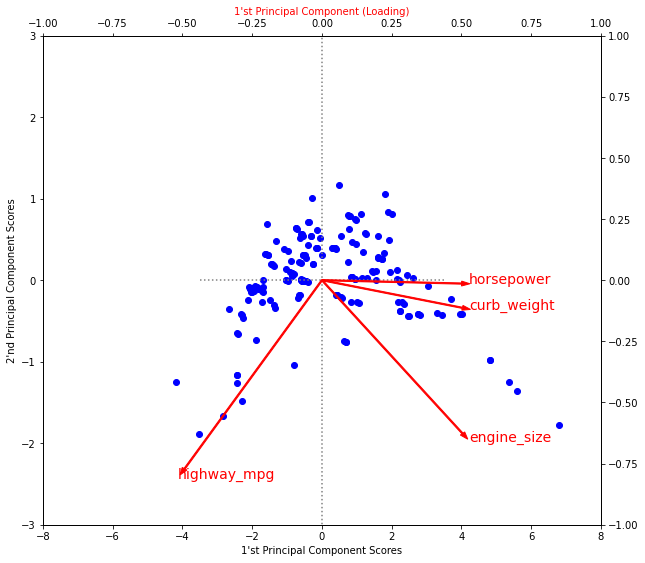

In [63]:
# biplot 
xvector = pca.components_[0] 
yvector = -pca.components_[1]

xs = X_pca.to_numpy()[:,0] 
ys = -X_pca.to_numpy()[:,1]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 9))

# First Plot : Principal Component Scores 
x_min, x_max = -8, 8
y_min, y_max = -3, 3
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')

ax1.set_xlabel("1'st Principal Component Scores")
ax1.set_ylabel("2'nd Principal Component Scores")

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

# Second Plot : Principal Component Loadings 'PCs' 
x_min, x_max = -1, 1          
y_min, y_max = -1, 1

ax2 = ax1.twinx().twiny()
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

for i in range(len(xvector)):
    ax2.arrow(0, 0, xvector[i],  yvector[i], color='red', width=0.005, head_width=0.02)
    ax2.annotate(X.columns[i], (xvector[i]*1.05, yvector[i]*1.05), color='red', size=14)  

    
ax2.set_xlabel("1'st Principal Component (Loading)", color='red')
ax2.set_ylabel("2'nd Principal Component (Loading)", color='red')

Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. The first component (`PC1`) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis. The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

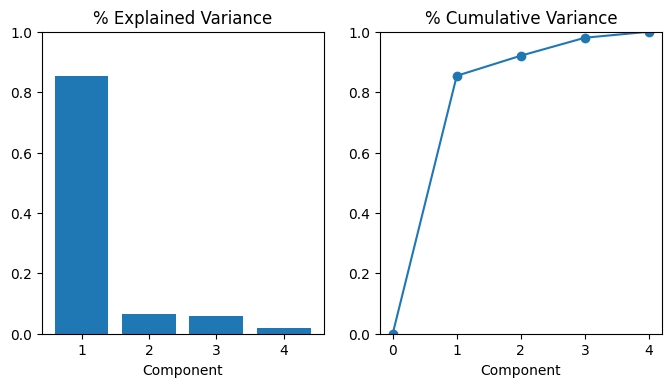

In [64]:
# Look at explained variance
plot_variance(pca)

Let's also look at the MI scores of the components. Not surprisingly, `PC1` is highly informative, though the remaining components, despite their small variance, still have a significant relationship with `price`. Examining those components could be worthwhile to find relationships not captured by the main Luxury/Economy axis.

In [65]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.013739
PC2    0.379649
PC3    0.306207
PC4    0.204905
Name: MI Scores, dtype: float64

The third component shows a contrast between `horsepower` and `curb_weight` -- sports cars vs. wagons, it seems.

In [66]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


To express this contrast, let's create a new ratio feature:

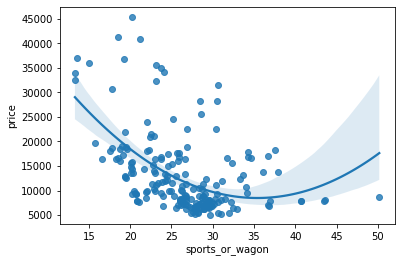

In [67]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);

## Manifold learning

#### t-SNE

In [68]:
digits = load_digits()

In [69]:
X = digits.images.reshape(-1, digits.images.shape[1]*digits.images.shape[2])
X.shape

(1797, 64)

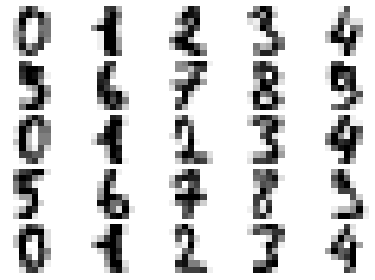

In [70]:
fig, ax_array = plt.subplots(5, 5)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [71]:
otsne = oTSNE(
    n_components=2,
    perplexity=30,
    initialization='pca', 
    n_jobs=2,
    random_state=0,
    negative_gradient_method='auto', 
    verbose=True,
)

In [72]:
embedding = otsne.fit(X)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=2, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.79 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.08 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=149.75 for 250 iterations...
Iteration   50, KL divergence 2.6162, 50 iterations in 0.5615 sec
Iteration  100, KL divergence 2.6249, 50 iterations in 0.4249 sec
Iteration  150, KL divergence 2.6110, 50 iterations in 0.5087 sec
Iteration  200, KL divergence 2.6054, 50 iterations in 0.4346 sec
Iteration  250, KL divergence 2.6028, 50 iterations in 0.4644 sec
   --> Time elapsed: 2.40 seconds
===> Running optimization with exaggeration=1.0

Text(0.5, 1.0, 'tSNE of the Digits dataset')

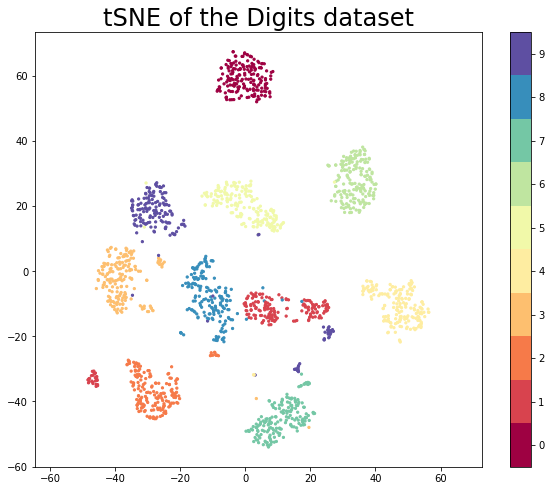

In [73]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('tSNE of the Digits dataset', fontsize=24)

#### UMAP

UMAP is useful for generating visualisations, but if you want to make use of UMAP more generally for machine learning tasks it is important to be be able to train a model and then later pass new data to the model and have it transform that data into the learned space. For example if we use UMAP to learn a latent space and then train a classifier on data transformed into the latent space then the classifier is only useful for prediction if we can transform data for which we want a prediction into the latent space the classifier uses. 

In [74]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, stratify=digits.target, random_state=42)

Now to get a benchmark idea of what we are looking at let’s train a couple of different classifiers and then see how well they score on the test set. For this example let’s try a support vector classifier and a KNN classifier.

In [75]:
svc = SVC(gamma='auto').fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)
svc.score(X_test, y_test), knn.score(X_test, y_test)

(0.62, 0.9844444444444445)

The goal now is to make use of UMAP as a preprocessing step that one could potentially fit into a pipeline. 

In [76]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(X_train)

Text(0.5, 1.0, 'Umap of the Digits dataset')

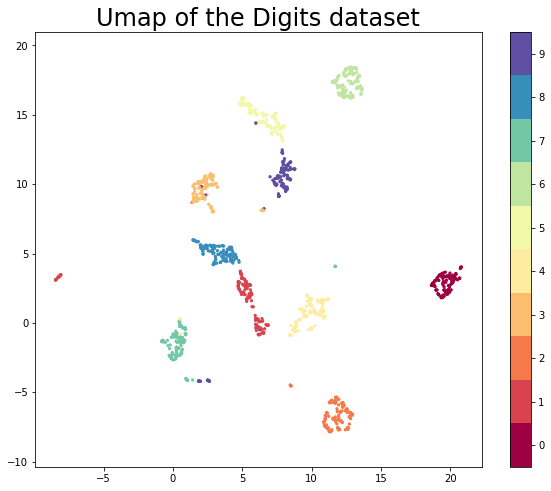

In [77]:
plt.figure(figsize=(10, 8))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Umap of the Digits dataset', fontsize=24)

This looks very promising! Most of the classes got very cleanly separated, and that gives us some hope that it could help with classifier performance. We can now train some new models (again an SVC and a KNN classifier) on the embedded training data. This looks exactly as before but now we pass it the embedded data. 

In [78]:
svc = SVC(gamma='auto').fit(trans.embedding_, y_train)
knn = KNeighborsClassifier().fit(trans.embedding_, y_train)

In [79]:
test_embedding = trans.transform(X_test)

The next important question is what the transform did to our test data. In principle we have a new two dimensional representation of the test-set, and ideally this should be based on the existing embedding of the training set

Text(0.5, 1.0, 'Umap of the Digits dataset')

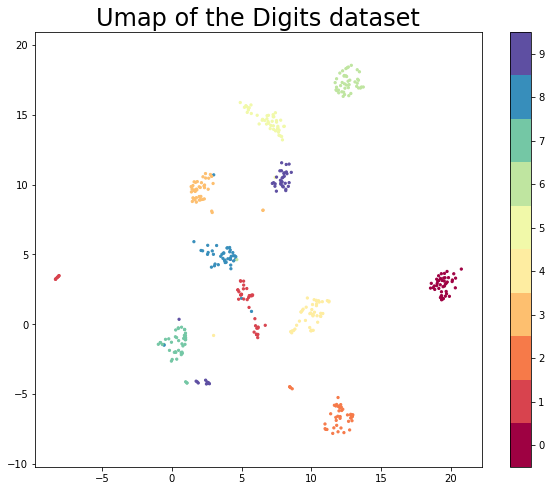

In [80]:
plt.figure(figsize=(10, 8))
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Umap of the Digits dataset', fontsize=24)

The results look like what we should expect; the test data has been embedded into two dimensions in exactly the locations we should expect (by class) given the embedding of the training data visualised above. This means we can now try out models that were trained on the embedded training data by handing them the newly transformed test set.

In [81]:
trans.transform(X_test)

array([[ 4.73177004e+00,  2.46851373e+00],
       [ 1.91173019e+01,  3.47619963e+00],
       [ 7.86290264e+00,  1.09972172e+01],
       [-8.19267273e+00,  3.35794115e+00],
       [ 7.09956217e+00,  1.42389803e+01],
       [ 1.32900066e+01,  1.82322578e+01],
       [ 2.65943050e-01, -8.95168245e-01],
       [ 8.13252068e+00,  1.00992136e+01],
       [ 5.73924875e+00,  2.07148552e+00],
       [ 5.40985489e+00,  1.51770325e+01],
       [ 6.47868681e+00,  1.46163197e+01],
       [ 7.92969179e+00,  9.91152573e+00],
       [ 1.17540598e+01, -5.85403776e+00],
       [ 1.21744642e+01, -6.17784595e+00],
       [ 6.87150419e-01, -2.17636895e+00],
       [ 1.28335676e+01,  1.65336361e+01],
       [ 6.92930698e+00,  1.49666691e+01],
       [ 1.00950708e+01,  6.95953965e-01],
       [ 3.05954218e+00,  4.18441391e+00],
       [ 1.22419624e+01,  1.81537476e+01],
       [ 8.41183376e+00,  1.01441069e+01],
       [ 9.57836246e+00,  2.75005311e-01],
       [ 1.93220310e+01,  2.32694030e+00],
       [ 1.

In [82]:
svc.score(trans.transform(X_test), y_test), knn.score(trans.transform(X_test), y_test)

(0.98, 0.98)

The results are pretty good. While the accuracy of the KNN classifier did not improve there was not a lot of scope for improvement given the data. On the other hand the SVC has improved to have equal accuracy to the KNN classifier!

For more interesting datasets the larger dimensional embedding might have been a significant gain – it is certainly worth exploring as one of the parameters in a grid search across a pipeline that includes UMAP.



## Clustering

When used for feature engineering, we could attempt to discover groups of customers representing a market segment, for instance, or geographic areas that share similar weather patterns. Adding a feature of cluster labels can help machine learning models untangle complicated relationships of space or proximity.

### Cluster Labels as a feature

Applied to a single real-valued feature, clustering acts like a traditional "binning" or "discretization" transform. On multiple features, it's like "multi-dimensional binning" (sometimes called *vector quantization*).

It's important to remember that this Cluster feature is categorical. Here, it's shown with a label encoding (that is, as a sequence of integers) as a typical clustering algorithm would produce; depending on your model, a one-hot encoding may be more appropriate. The motivating idea **for adding cluster labels is that the clusters will break up complicated relationships across features into simpler chunks**. Our model can then just learn the simpler chunks one-by-one instead having to learn the complicated whole all at once. It's a "divide and conquer" strategy.

As spatial features, [*California Housing*](https://www.kaggle.com/camnugent/california-housing-prices)'s `'Latitude'` and `'Longitude'` make natural candidates for k-means clustering. In this example we'll cluster these with `'MedInc'` (median income) to create economic segments in different regions of California. Since k-means clustering is sensitive to scale, it can be a good idea rescale or normalize data with extreme values. Our features are already roughly on the same scale, so we'll leave them as-is.

In [83]:
df = fetch_california_housing(as_frame=True)['frame']

In [84]:
X = df.loc[:, ["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [85]:
# Create cluster feature
kmeans = KMeans(n_clusters = 6, n_init = 10)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,MedInc,Latitude,Longitude,Cluster
0,8.3252,37.88,-122.23,5
1,8.3014,37.86,-122.22,5
2,7.2574,37.85,-122.24,5
3,5.6431,37.85,-122.25,5
4,3.8462,37.85,-122.25,1


Notice the differnece between `predict()` and `transform()` in the KMeans. `predict()` will predict the closest cluster each sample in `X` belongs to. `transform()` will transform data to a cluster-distance space where each dimension is the distance to the cluster centers.


Now let's look at a couple plots to see how effective this was. First, a scatter plot that shows the geographic distribution of the clusters. It seems like the algorithm has created separate segments for higher-income areas on the coasts.

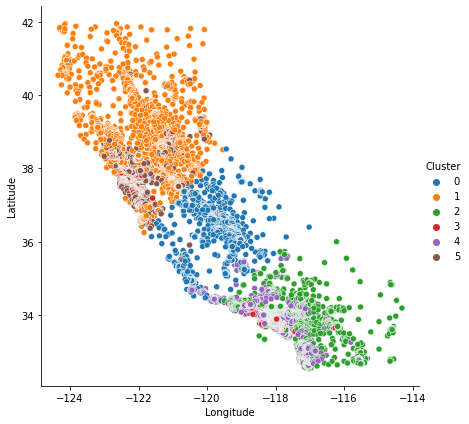

In [86]:
sns.relplot(
    x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
);

The target in this dataset is `MedHouseVal` (median house value). These box-plots show the distribution of the target within each cluster. If the clustering is informative, these distributions should, for the most part, separate across `MedHouseVal`, which is indeed what we see.

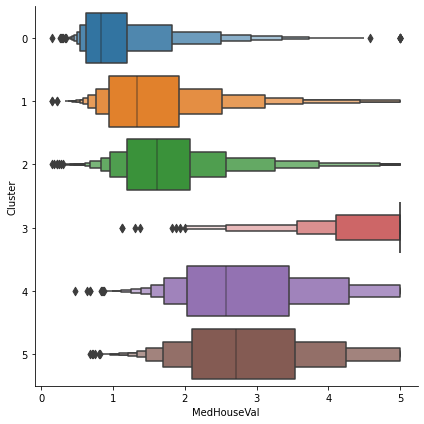

In [87]:
X["MedHouseVal"] = df["MedHouseVal"]
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);

### Cluster distance as a feature

In [88]:
X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [89]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [90]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. **We will create a pipeline that will first cluster the training set into 30 clusters and replace the images with their distances to the 30 clusters**, then apply a logistic regression model:

In [91]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=30, random_state=42, n_init=10)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=30, n_init=10, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [93]:
X_train.shape

(1347, 64)

In [94]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9733333333333334

How much did the error rate drop?

In [95]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.1428571428571439

We reduced the error rate by over 14%! 

## Guideline to determine the optimal number of features or threshold?

To determine the optimal hyperparameter, we can use cross validation. For instance, in the above example, we chose the number of clusters `k` completely arbitrarily. However, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for `k` is the best value of `k` is simply the one that results in the best classification performance.

In [ ]:
# The following cell may take close to 20 minutes to run, or more depending on your hardware!
param_grid = dict(kmeans__n_clusters=range(2, 60))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

In [ ]:
grid_clf.best_params_

In [ ]:
grid_clf.score(X_test, y_test)

In the same way, you can also use cross-validation to evaluate model performance with different numbers of top-ranked features or different numbers of features and choose the optimal number based on the performance metric (e.g., highest accuracy or lowest error).

### Using Clustering for Semi-Supervised Learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

In [96]:
X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [97]:
n_labeled = 50

In [98]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

The model’s accuracy is just 83.33%. It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's **find the image closest to the centroid. We will call these images the representative images:**

In [99]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

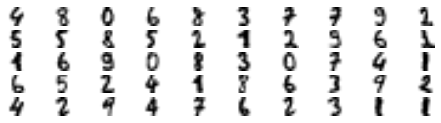

In [100]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show()

In [101]:
# Assuming we manually label these digits
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [102]:
y_representative_digits = y_train[representative_digit_idx]

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [103]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

We jumped from 83.3% accuracy to 92.2%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: **what if we propagated the labels to all the other instances in the same cluster?**

In [104]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [105]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [106]:
log_reg.score(X_test, y_test)

0.9333333333333333

We got a tiny little accuracy boost. Better than nothing, **but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers.** Let's only propagate the labels to the 75th percentile closest to the centroid:

In [107]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [108]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [109]:
X_train.shape, X_train_partially_propagated.shape

((1347, 64), (1003, 64))

In [110]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [111]:
log_reg.score(X_test, y_test)

0.9355555555555556

A bit better. With just 50 labeled instances (just 5 examples per class on average!), we got 93.5% performance, which is getting closer to the performance of logistic regression on the fully labeled digits dataset.

Our propagated labels are actually pretty good: their accuracy is about 97.5%:

In [112]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9750747756729811

You could also do a few iterations of active learning:

1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

### Feature agglomeration

`cluster.FeatureAgglomeration` applies Hierarchical clustering to group together features that behave similarly.

In [113]:
X, y = load_iris(return_X_y=True)

In [114]:
#set n_clusters to 2, the output will be two columns of agglomerated features (iris has 4 features)
agglo = FeatureAgglomeration(n_clusters=2).fit_transform(X)

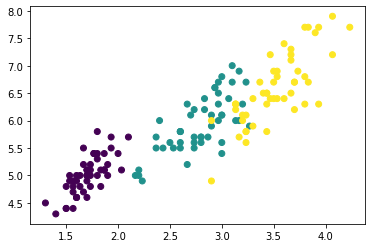

In [115]:
plt.scatter(agglo[:,0], agglo[:,1],c=y)
plt.show()

## References

1. [https://www.kaggle.com/learn/feature-engineering](https://www.kaggle.com/learn/feature-engineering)
2. [https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html#](https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html#) 
3. [https://scikit-learn.org/stable/modules/feature_selection.html](https://scikit-learn.org/stable/modules/feature_selection.html) 
4. [https://scikit-learn.org/stable/modules/preprocessing.html#](https://scikit-learn.org/stable/modules/preprocessing.html#) 
5. [https://scikit-learn.org/stable/modules/unsupervised_reduction.html](https://scikit-learn.org/stable/modules/unsupervised_reduction.html  )
6. [https://github.com/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynb](https://github.com/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynb)